In [2]:
import numpy as np
import numpy.random as random
import pandas as pd
import scipy as sp
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

%precision 3

import sklearn
import requests, zipfile
import io

In [3]:
#데이터 수집
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content

#수집한 데이터를 DataFrame 객체로 읽어 들이기
mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

#데이터 컬럼에 레이블 설정
mushroom.columns =['classes', 'cap_shape', 'cap_surface', 'cap_color', 'odor', 'bruises',
                   'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape',
                   'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring',
                   'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color',
                   'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat']

#처음 다섯 행 출력
mushroom.head()

,classes,cap_shape,cap_surface,cap_color,odor,bruises,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
print('데이터 형태: {}'.format(mushroom.shape))
print('결측값 수: {}'.format(mushroom.isnull().sum().sum()))

데이터 형태: (8124, 23)
결측값 수: 0


In [5]:
mushroom_dummy = pd.get_dummies(mushroom[['gill_color', 'gill_attachment', 'odor', 'cap_color']])
mushroom_dummy.head()

,gill_color_b,gill_color_e,gill_color_g,gill_color_h,gill_color_k,gill_color_n,gill_color_o,gill_color_p,gill_color_r,gill_color_u,...,cap_color_b,cap_color_c,cap_color_e,cap_color_g,cap_color_n,cap_color_p,cap_color_r,cap_color_u,cap_color_w,cap_color_y
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
#목표변수도 수치화(0/1)함
mushroom_dummy['flg'] = mushroom['classes'].map(lambda x: 1 if x =='p' else 0)

In [7]:
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap_color_c,,
0,4176,3904
1,32,12


In [8]:
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill_color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [9]:
#p1 = p2 = 0.5일 경우의 엔트로피
- (0.5 * np.log2(0.5) + 0.5 * np.log2(0.5))

1.000

In [10]:
#p1 = 0.001, p2 = 0.999일 경우의 엔트로피
- (0.001 * np.log2(0.001) + 0.999 * np.log2(0.999))

0.011

In [11]:
def calc_entropy(p):
    return - (p * np.log2(p) + (1 - p) * np.log2(1 - p))

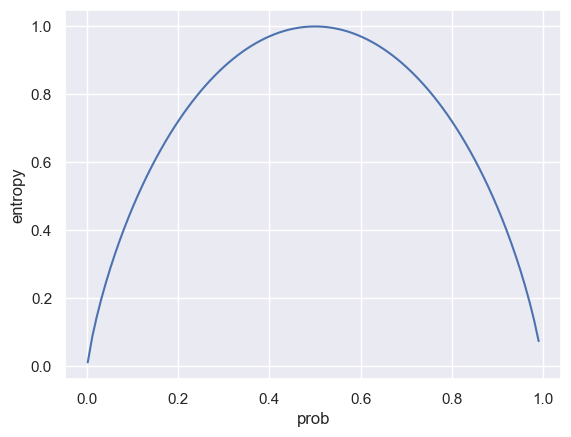

In [12]:
p = np.arange(0.001, 0.999, 0.01)

plt.plot(p, calc_entropy(p))
plt.xlabel('prob')
plt.ylabel('entropy')
plt.grid(True)

In [13]:
mushroom_dummy.groupby('flg')['flg'].count()

flg
0    4208
1    3916
Name: flg, dtype: int64

In [14]:
entropy_init = - (0.518 * np.log2(0.518) + 0.482 * np.log2(0.482))
print('독버섯 데이터 엔트로피 초깃값: {:.3f}'.format(entropy_init))

독버섯 데이터 엔트로피 초깃값: 0.999


In [15]:
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap_color_c,,
0,4176,3904
1,32,12


In [16]:
p1 = 4176 / (4176 + 3904)
p2 = 1 - p1
entropy_c0 = -(p1 * np.log2(p1) + p2 * np.log2(p2))
print('entropy_c0: {:.3f}'.format(entropy_c0))

entropy_c0: 0.999


In [17]:
p1 = 32 / (32 + 12)
p2 = 1 - p1
entropy_c1 = - (p1 * np.log2(p1) + p2 * np.log2(p2))
print('entropy_c1: {:.3f}'.format(entropy_c1))

entropy_c1: 0.845


In [18]:
entropy_after = (4176 + 3904) / 8124 * entropy_c0 + (32 + 12) / 8124 * entropy_c1
print('데이터 분할 후 평균 엔트로피: {:.3f}'.format(entropy_after))


데이터 분할 후 평균 엔트로피: 0.998


In [19]:
print('변수 cap_color 기준으로 분할했을 때의 정보이득: {:.3f}'.format(entropy_init - entropy_after))

변수 cap_color 기준으로 분할했을 때의 정보이득: 0.001


In [20]:
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill_color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [21]:
#gill_color가 b가 아닌 경우 엔트로피
p1 = 4208/(4208+2199)
p2 = 1 - p1
entropy_b0 = - (p1 * np.log2(p1) + p2 * np.log2(p2))

#gill_color가 b인 경우 엔트로피
p1 = 0/(0+1728)
p2 = 1 - p1
entropy_b1 = - (p2 * np.log2(p2))

entropy_after = (4208 + 2188) / 8124 * entropy_b0 + (0 + 1728) / 8124 * entropy_b1
print('변수 gill_color 기준으로 분할했을 때의 정보이득: {:.3f}'.format(entropy_init - entropy_after))


변수 gill_color 기준으로 분할했을 때의 정보이득: 0.269


In [22]:
#의사결정 모델 구축

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#데이터 분할
X = mushroom_dummy.drop('flg', axis=1)
y = mushroom_dummy['flg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#의사결정나무 클래스 초기화와 학습
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
model.fit(X_train, y_train)

print('정확도(train):{:.3f}'.format(model.score(X_train, y_train)))
print('정확도(test):{:.3f}'.format(model.score(X_test, y_test)))


정확도(train):0.883
정확도(test):0.894


In [27]:
X_train.groupby(['gill_color_b', 'odor_f'])['gill_color_b'].count().unstack()

odor_f,0,1
gill_color_b,,
0,2528.0,2263.0
1,NaN,1302.0


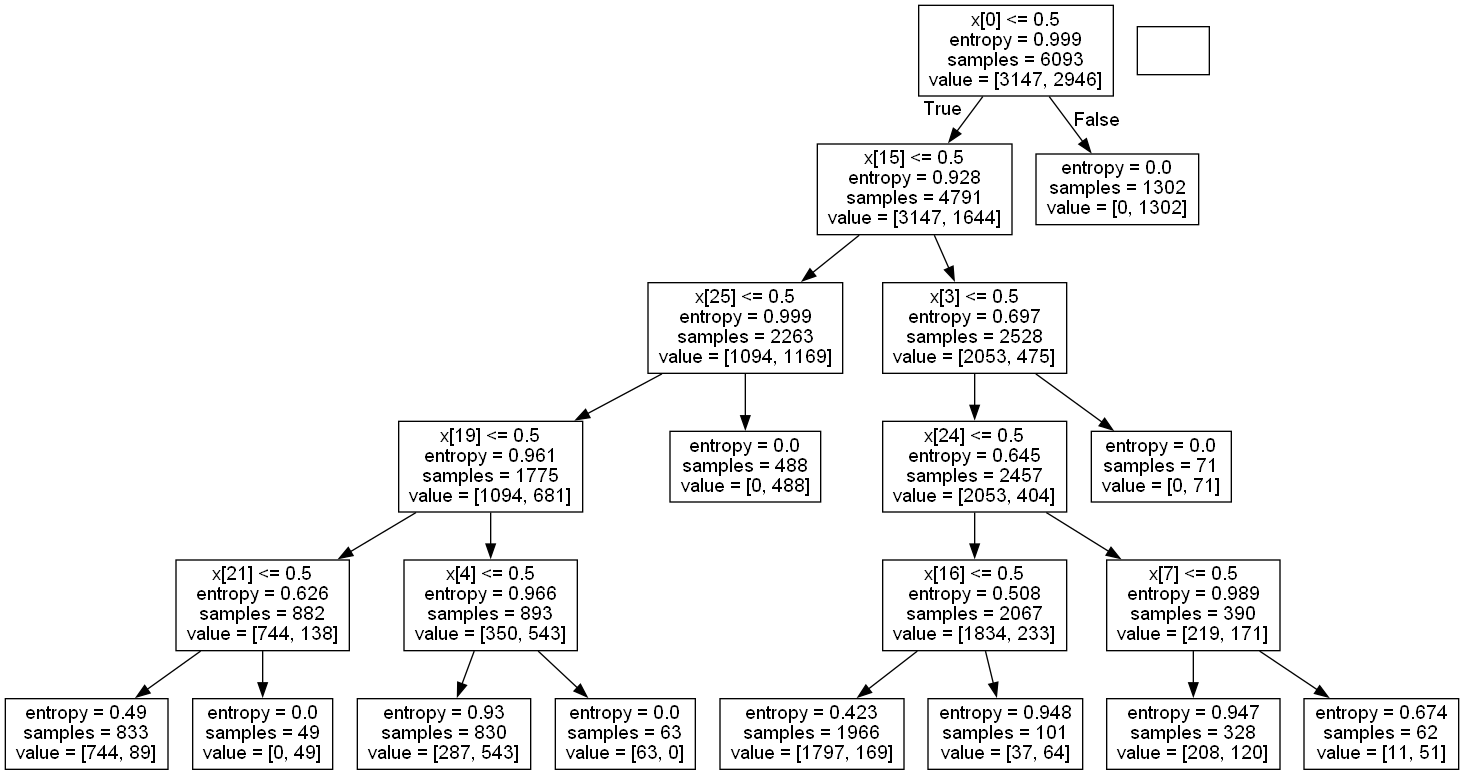

In [ ]:
from sklearn import tree
from six import StringIO
import pydotplus
from IPython.display import Image

dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())